<a href="https://colab.research.google.com/github/MiaMiya/02807-Computational-Tools-for-Data-Science/blob/main/Week5/slides_week5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 02807 - Computational Tools for Data Science - Week 5

# Today
    
* Use **Pandas** to 
    * Perform merge/join operations as a means of "concatenating columns" (combining data frames)
    * Calculate correlation and its interpretation
* Presentation of Project 1
* Live group formation - please stay in auditorium if you lack a group or a group member

In [1]:
import pandas as pd

# Merge/join - "column concatenation"

* `merge` (or its simpler sibling `join`) allow us to fuse together columns from two data frames into a single data frame. 
* We typically fuse based on some common value (merge key) found in both data frames.
    * In this way, we don't have to assume the two data frames have the exact same rows/ordering, we just specify a shared value on which the fusion takes place
    * Merge key specified using either `on`, `left_on`/`right_on`, or `left_index`/`right_index`.
* Output depends on join category, which is a function of the *input* data frames
    * One-to-one: The merge key is found at most once in both data frames.
    * Many-to-one: The merge key occurs multiple times in one of the data frames, and at most once in the other.
    * Many-to-many: The merge key occurs multiple times in both data frames.
    * In general, the output is a "multiplication" (restricted cross product) of values
        * E.g. in a Many-to-one the "Many" values will be preserved in the resulting data frame with the "one" being duplicated.
* Set arithmetic (via `how` specification) is e.g. `inner`, `left`, `right`, `outer`
    *  When a value appears in one merge key column but not the other, what should happen to that value?

We create aggregate dataframes for two different years, where then `country` is a common value in both data frames. In effect, we're dealing with a One-to-one join category.

In [2]:
url = 'http://courses.compute.dtu.dk/02807/2021/lectures/week4/timesData.csv'
df_times = pd.read_csv(url)

country_teaching_2014 = df_times[df_times.year==2014].groupby('country').agg({'teaching': 'mean'})
country_teaching_2015 = df_times[df_times.year==2015].groupby('country').agg({'teaching': 'mean'})

In [ ]:
from IPython.display import display

# Observe the overlap in indices; i.e. this is the shared value/merge key
display(country_teaching_2014.head(5), country_teaching_2015.head(5))

,teaching
country,
Australia,29.857895
Austria,28.450000
Belgium,33.142857
Brazil,44.250000
Canada,36.721053


,teaching
country,
Australia,32.320000
Austria,30.940000
Belgium,35.971429
Brazil,47.500000
Canada,38.983333


We first see the shape differ, and then which countries differ between the two years

In [ ]:
countries_differing = country_teaching_2014.index.union(country_teaching_2015.index) \
                      .difference(country_teaching_2014.index.intersection(country_teaching_2015.index))

country_teaching_2014.shape, country_teaching_2015.shape, countries_differing

((40, 1),
 (41, 1),
 Index(['Chile', 'Estonia', 'Macau', 'Morocco', 'Saudi Arabia'], dtype='object', name='country'))

Because there are such differences in country values, the type of fusion we do matter for the final result. Specifically, if a country only exists in one of the dataframes, what should happen to the values of that country?

In [ ]:
display(country_teaching_2014[country_teaching_2014.index.isin(countries_differing)],
        country_teaching_2015[country_teaching_2015.index.isin(countries_differing)])

,teaching
country,
Estonia,20.3
Saudi Arabia,19.8


,teaching
country,
Chile,13.0
Macau,17.1
Morocco,16.3


## Inner merge/join: Keep countries only if present in both

In [ ]:
country_teaching_inner = \
country_teaching_2014 \
    .merge(country_teaching_2015, how='inner', left_index=True, right_index=True, suffixes=('_2014', '_2015'))

display(country_teaching_inner.head(5))
# No NaN values; but less data than in original data frames
country_teaching_inner.shape

,teaching_2014,teaching_2015
country,,
Australia,29.857895,32.320000
Austria,28.450000,30.940000
Belgium,33.142857,35.971429
Brazil,44.250000,47.500000
Canada,36.721053,38.983333


(38, 2)

## Left merge/join: Keep countries present in 2014 (left data frame)

In [ ]:
country_teaching_left = \
country_teaching_2014 \
    .merge(country_teaching_2015, how='left', left_index=True, right_index=True, suffixes=('_2014', '_2015'))
# Shape of join is same as left data frame
display(country_teaching_left[country_teaching_left.index.isin(countries_differing)].head(5))
country_teaching_left.shape

,teaching_2014,teaching_2015
country,,
Estonia,20.3,NaN
Saudi Arabia,19.8,NaN


(40, 2)

## Right merge/join: Keep countries present in 2015 (right data frame)

In [ ]:
country_teaching_right = \
country_teaching_2014 \
    .merge(country_teaching_2015, how='right', left_index=True, right_index=True, suffixes=('_2014', '_2015'))
# Shape of join is same as right data frame
display(country_teaching_right[country_teaching_right.index.isin(countries_differing)].head(5))
country_teaching_right.shape

,teaching_2014,teaching_2015
country,,
Chile,NaN,13.0
Macau,NaN,17.1
Morocco,NaN,16.3


(41, 2)

## Outer merge/join: Keep countries present in either data frame

In [ ]:
country_teaching_outer = \
country_teaching_2014 \
    .merge(country_teaching_2015, how='outer', left_index=True, right_index=True, suffixes=('_2014', '_2015'))

country_teaching_outer.shape
# Shape of join as the union of the indices

(43, 2)

Except for inner join, the other join types leave us with empty values in one of the columns, if the indices of the two dataframes are not the same (as they aren't in this example).

In [ ]:
# country_teaching_inner discards Chile, Macau, Morocco, Estonia, Saudi Arabia
# country_teaching_left discards Chile, Macau, Morocco
# country_teaching_right discards Estonia, Saudi Arabia
country_teaching_outer.loc[countries_differing]

,teaching_2014,teaching_2015
country,,
Chile,NaN,13.0
Estonia,20.3,NaN
Macau,NaN,17.1
Morocco,NaN,16.3
Saudi Arabia,19.8,NaN


# Correlation: NY Hotels

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [ ]:
url = 'https://raw.githubusercontent.com/s-heisler/pycon2017-optimizing-pandas/master/pyCon%20materials/new_york_hotels.csv'
df_ny = pd.read_csv(url, encoding='cp1252')

# Here pairing is done over rows, so each row represents a sample in the below equation
df_ny[['star_rating', 'high_rate']].sample(6)

,star_rating,high_rate
883,4.5,595.0000
669,2.5,179.1474
712,3.0,344.0000
1222,2.5,69.9900
136,3.0,139.2400
410,2.0,131.4400


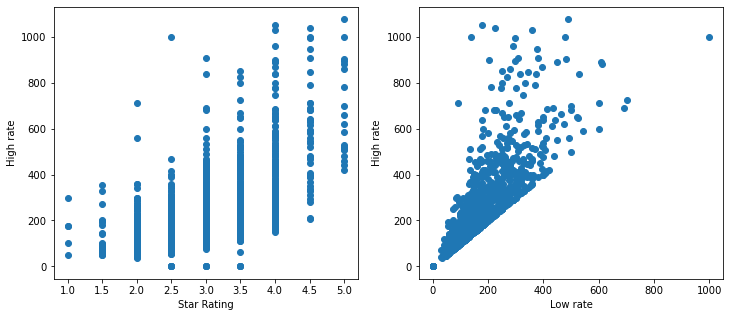

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Removing elements above the 98-percentile
df_ny_rates = df_ny[df_ny.high_rate < df_ny.high_rate.quantile(0.98)] \
    .dropna(subset=['star_rating', 'high_rate'])

ax[0].scatter(df_ny_rates.star_rating, df_ny_rates.high_rate)
ax[0].set_xlabel('Star Rating')
_ = ax[0].set_ylabel('High rate')

ax[1].scatter(df_ny_rates.low_rate, df_ny_rates.high_rate)
ax[1].set_xlabel('Low rate')
_ = ax[1].set_ylabel('High rate')

# calc the regression line: How well can we predict/describe High rate based on star rating?
# NOT the same as correlation, though overlap in use cases
# z = np.polyfit(df_ny_rates.star_rating, df_ny_rates.high_rate, 1)
# p = np.poly1d(z)
# ax[0].plot(df_ny_rates.star_rating, p(df_ny_rates.star_rating),"g--")

# z = np.polyfit(df_ny_rates.low_rate, df_ny_rates.high_rate, 1)
# p = np.poly1d(z)
# _ = ax[1].plot(df_ny_rates.low_rate, p(df_ny_rates.low_rate),"g--")


In [ ]:
# What's the sample correlation r_{xy} for two x's and y=high_rate
df_ny['star_rating'].corr(df_ny['high_rate']), df_ny['low_rate'].corr(df_ny['high_rate'])

(0.4578312614942432, 0.7653249765793299)

The sample Pearson correlation coefficient over paired samples $\{ (x_1,y_1),\ldots,(x_n,y_n) \}$ is given by

$r_{xy} =\frac{\sum ^n _{i=1}(x_i - \bar{x})(y_i - \bar{y})}{\sqrt{\sum ^n _{i=1}(x_i - \bar{x})^2} \sqrt{\sum ^n _{i=1}(y_i - \bar{y})^2}}$

where:

* $n$ is sample size
* $x_i, y_i$ are the individual sample points indexed with $i$
* $\bar{x} = \frac{1}{n} \sum_{i=1}^n x_i$ (is the sample mean); and analogously for $\bar{y}$

$r_{xy}$ indicates the extent to which the two variables $x$ and $y$ "move" together. Consider in particular the cases where the numerator is always either positive or negative on a given dataset.

Consider the image below for interpretation of $r_{xy}$. 

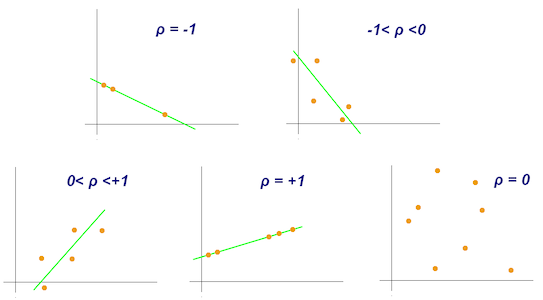

In [ ]:
# Compute correlation of all columns with high_rate
df_ny.corrwith(df_ny.high_rate).to_frame().T

,ean_hotel_id,latitude,longitude,star_rating,high_rate,low_rate
0,-0.009524,-0.231536,0.152842,0.457831,1.0,0.765325


In [ ]:
# Compute correlation for all pairs of columns
# It's a symmetric matrix with 1's in the diagonal
# Observe the values we also found in the code cells above appears here
# Is applied only to numeric columns
df_ny.corr()

,ean_hotel_id,latitude,longitude,star_rating,high_rate,low_rate
ean_hotel_id,1.000000,-0.105138,0.045289,0.065347,-0.009524,0.031447
latitude,-0.105138,1.000000,-0.574376,-0.369289,-0.231536,-0.253724
longitude,0.045289,-0.574376,1.000000,0.244953,0.152842,0.178270
star_rating,0.065347,-0.369289,0.244953,1.000000,0.457831,0.441211
high_rate,-0.009524,-0.231536,0.152842,0.457831,1.000000,0.765325
low_rate,0.031447,-0.253724,0.178270,0.441211,0.765325,1.000000


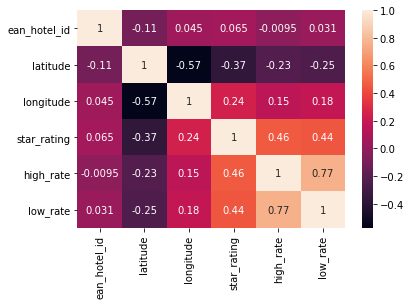

In [ ]:
# Get a heat-map visualisation of the correlation matrix
import seaborn as sns
sns.heatmap(df_ny.corr(), annot=True)
plt.show()

# Practical take-away

* To combine columns from data frames, using a column whose values appear in both, use `merge`/`join`
    * If there's missing merge keys, the `how` (inner, outer, left, right) determines what happens to unmatched rows
* Pandas can compute correlation statistics for us, telling us how much paired sample data "moves together"